# Kilonova surrogate modelling with $\texttt{jax}$ and $\texttt{flax}$

**Abstract:** NMMA allows users to build kilonova models. In case you want to get your hands dirty and adapt or extend the kilonova modelling, it could be helpful to break down the source code and see the intermediate steps that are performed in building these models to for instance gain insight into the training data. This notebook shows the different preprocessing steps before building the models as guideline to users. Afterwards, we train a neural network as surrogate model using $\texttt{jax}$ and $\texttt{flax}$. More information on these packages can be found on their Github repos. Currently, code has been implemented that can train an NN on the SVD representation. 

Future work:
- Add a learning rate scheduler in order to train the networks until convergence.
- The NN currently is trained on SVD data. We have to apply the inverse transform to obtain the lightcurves from the surrogate model and test its performance on a separated validation/test set to finetune the architecture and be able to compare different surrogate models.
- One can wonder whether with neural networks, we *really* need the SVD step. Previous work has considered an approach where a variational autoencoder architecture was used as surrogate model (see [this paper](https://arxiv.org/abs/2204.00285)). While this method requires more work to implement, we could try to train the NN directly on the lightcurve data instead of its SVD representation as a first step. 

In [50]:
# Basic imports
#general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
from astropy.time import Time
import copy
import scipy
#nmma modules
# sys.path.append('/Users/Woute029/Code/nmma') #path to nmma
from nmma.em import training
import afterglowpy as grb
import nmma as nmma
import functools

%load_ext autoreload 
%autoreload 2

# To get the relevant plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring and preprocessing data

Specify the location of the lightcurves that are used as grid for interpolation. 

In [51]:
# Location of the kilonova lightcurves
lcs_dir = "/Users/Woute029/Documents/KN_Lightcurves/lightcurves/lcs_bulla_2022"
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

There are 7700 lightcurves for this model.


To briefly explore the lightcurve data, let us load in a single lightcurve. Note the formatting: this is also what is written in `nmma/em/io` that can process lightcurve files. For convenience, we rename the first column.

In [52]:
dat = pd.read_csv(os.path.join(lcs_dir, filenames[0]), delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
dat

t  bessellux  bessellb  bessellv  bessellr  besselli   sdssu  ps1::g  \
0    0.103    -15.361   -15.377   -15.192   -14.957   -15.142 -15.400 -15.083   
1    0.109    -17.981   -18.327   -17.994   -17.865   -17.313 -18.045 -18.107   
2    0.116    -18.303   -17.752   -17.570   -17.637   -17.101 -18.346 -17.857   
3    0.122    -18.193   -17.729   -17.856   -17.870   -17.120 -18.175 -17.523   
4    0.130    -18.391   -18.425   -17.740   -17.651   -17.797 -18.361 -18.217   
..     ...        ...       ...       ...       ...       ...     ...     ...   
95  24.532        NaN    42.820     8.469    -2.312    -5.455   8.423  39.215   
96  25.987        NaN    25.400     7.332    -2.066    -4.865   2.813  21.797   
97  27.528        NaN    49.912    19.402    -0.635    -3.525   7.795  48.103   
98  29.160     58.756       NaN     3.824    -1.581    -3.732   2.394  49.495   
99  30.890        inf       inf       inf       inf       inf     inf     inf   

    ps1::r  ps1::i  ...  uvot::white  atlasc  atlaso  2massj  2massh  2massks  \
0  -15.069 -14.145  ...      -15.522 -15.189 -14.757 -14.788 -11.856   12.727   
1  -17.978 -17.423  ...      -18.421 -17.913 -17.795 -13.012 -13.678   -3.248   
2  -17.512 -17.707  ...      -18.376 -17.727 -17.652 -13.518 -16.154  -11.411   
3  -17.874 -16.992  ...      -18.381 -17.791 -17.614 -16.271 -17.455  -15.149   
4  -17.755 -17.160  ...      -18.325 -18.074 -17.532 -16.811 -13.814   -5.180   
..     ...     ...  ...          ...     ...     ...     ...     ...      ...   
95   6.848  -4.753  ...        5.030   7.731  -3.712 -10.826 -11.521  -12.430   
96   7.107  -4.196  ...        4.159   7.712  -3.199 -10.564 -11.189  -12.299   
97  14.768  -2.628  ...        5.195     NaN  -1.617 -10.265 -11.054  -12.045   
98  -0.689  -3.339  ...        3.222     NaN  -2.510  -9.888 -10.604  -11.653   
99     inf     inf  ...          inf     inf     inf     inf     inf      inf   

      ztfg    ztfr    ztfi  Unnamed: 27  
0  -15.223 -14.879 -14.911          NaN  
1  -18.047 -17.902 -17.417          NaN  
2  -17.893 -17.696 -17.301          NaN  
3  -17.562 -17.835 -16.881          NaN  
4  -18.237 -17.698 -17.634          NaN  
..     ...     ...     ...          ...  
95  42.057   3.580  -5.235          NaN  
96  24.640   3.563  -4.719          NaN  
97  47.556  14.391  -3.027          NaN  
98  50.387  -0.605  -3.504          NaN  
99     inf     inf     inf          NaN  

[100 rows x 28 columns]

In [53]:
print(dat.columns)
value_columns = dat.columns[1:-1]
print(value_columns)

Index(['t', 'bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli',
       'sdssu', 'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', 'uvot::b',
       'uvot::u', 'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v',
       'uvot::white', 'atlasc', 'atlaso', '2massj', '2massh', '2massks',
       'ztfg', 'ztfr', 'ztfi', 'Unnamed: 27'],
      dtype='object')
Index(['bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli', 'sdssu',
       'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', 'uvot::b', 'uvot::u',
       'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v', 'uvot::white',
       'atlasc', 'atlaso', '2massj', '2massh', '2massks', 'ztfg', 'ztfr',
       'ztfi'],
      dtype='object')


Below, we show the plot of a single lightcurve.

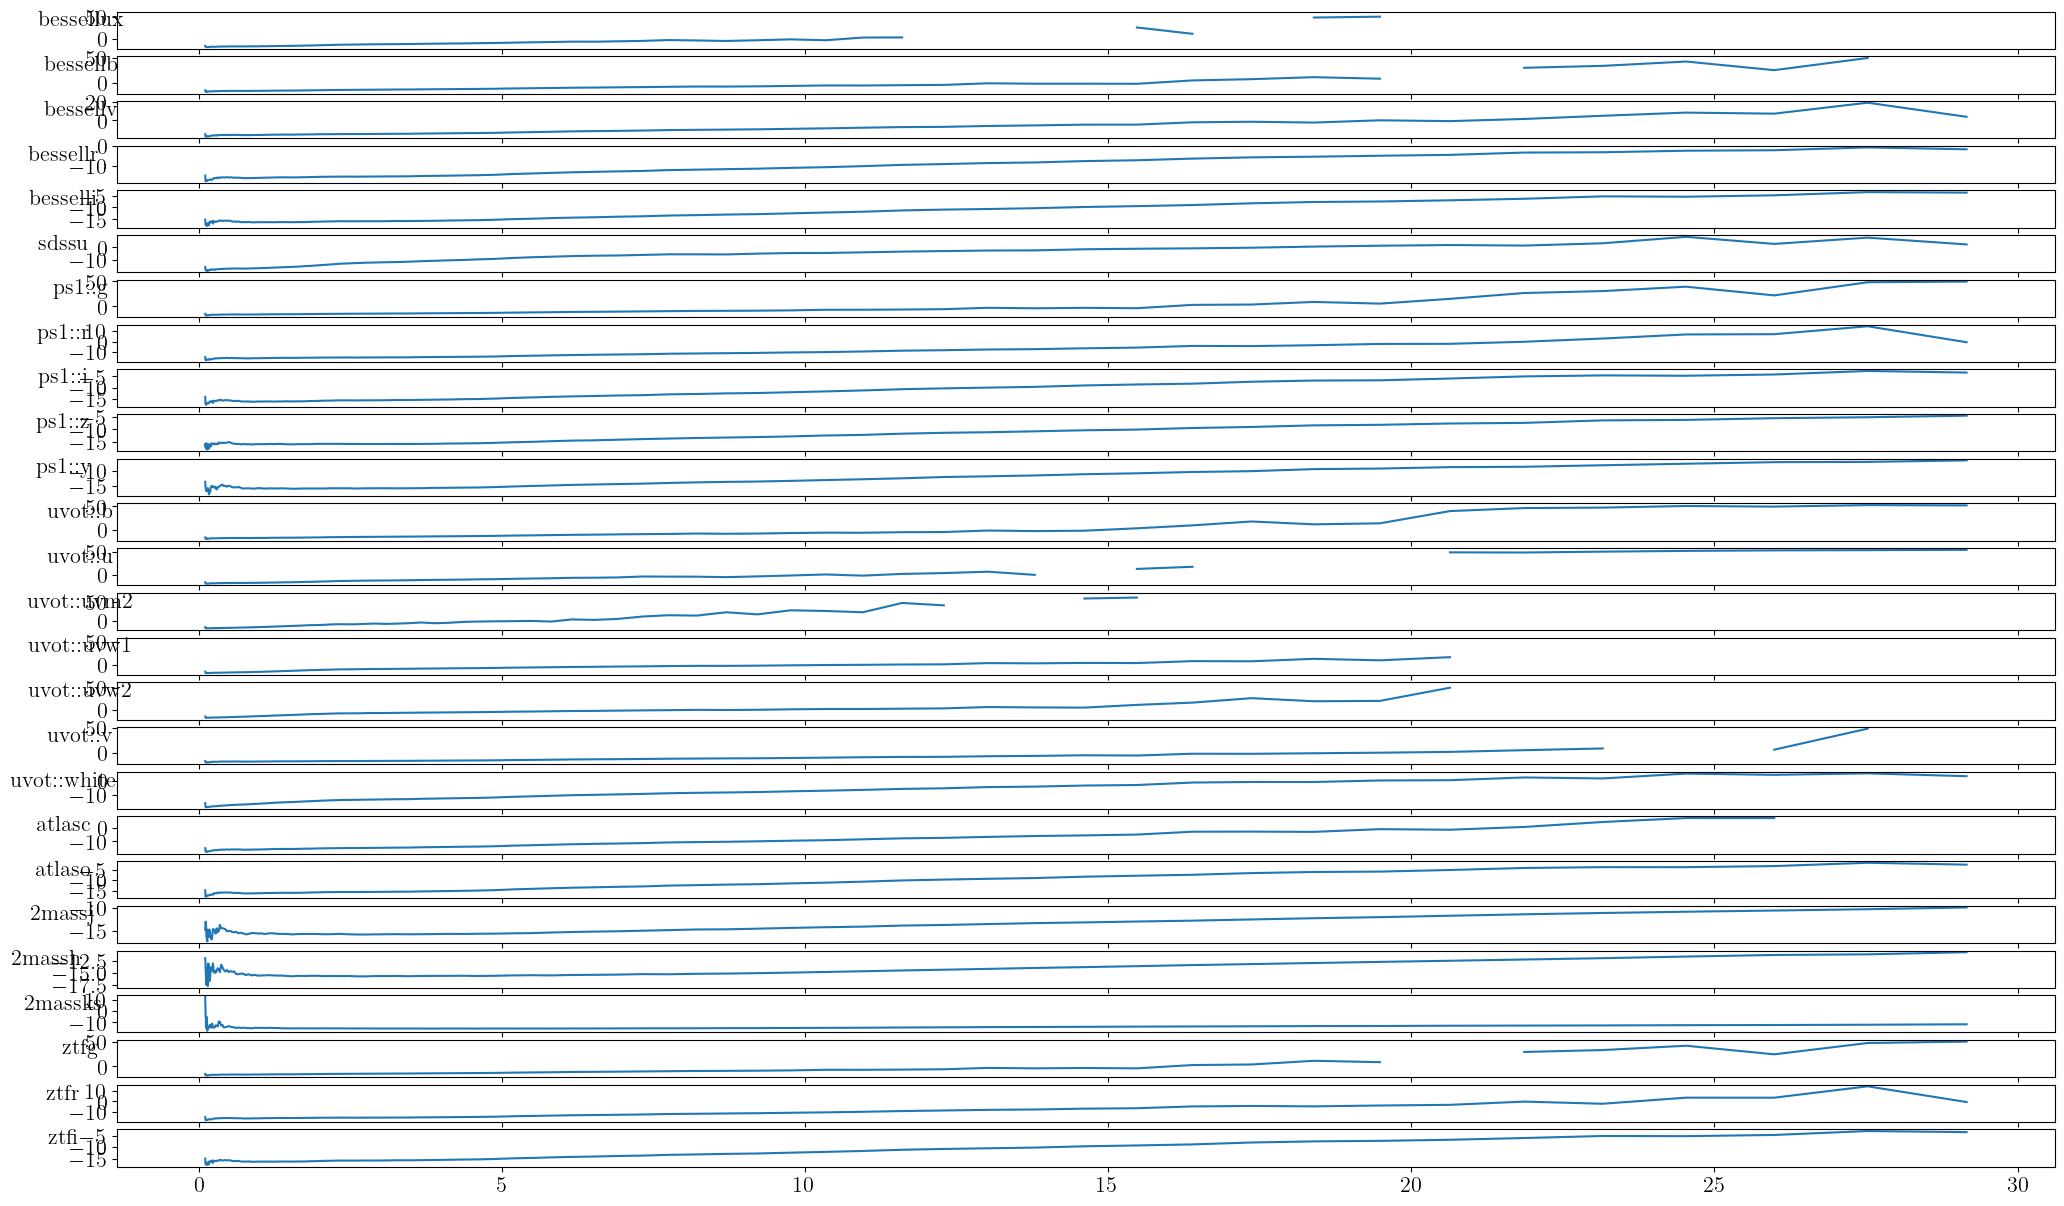

In [54]:
nrow = len(value_columns)
plt.subplots(nrow, 1, figsize=(25, 15), sharex = True)
t = dat["t"].values

for i, key in enumerate(value_columns):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, dat[key].values)
    plt.ylabel(key, rotation=0)
    plt.grid()
plt.show()

Have to get the parameters out with NMMA. To read and process a bunch of photometry files as the above directory, use the `read_photometry_files` function from NMMA from the `io` script. This creates a dictionary with keys being the filenames of youyr lightcurves, and values being the above Pandas dataframe as dictionary. **Note:** This can take a while if you have a large grid.

In [55]:
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans

In [56]:
data = read_photometry_files(full_filenames)
# Interpolate nans
data = interpolate_nans(data)

In order to process the data, NMMA needs to know which kind of data file you are using. This is needed in order to extract the parameters out of the filenames. In `model_parameters`, there is an overview of which lightcurves are supported for extracting the parameters:

In [57]:
import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS

{'get_knprops_from_LANLfilename': <function nmma.em.utils.get_knprops_from_LANLfilename(filename)>,
 'AnBa2022_linear': <function nmma.em.model_parameters.AnBa2022_linear(data)>,
 'AnBa2022_log': <function nmma.em.model_parameters.AnBa2022_log(data)>,
 'AnBa2022_sparse': <function nmma.em.model_parameters.AnBa2022_sparse(data)>,
 'CV': <function nmma.em.model_parameters.CV(data)>,
 'Bu2019lm_sparse': <function nmma.em.model_parameters.Bu2019lm_sparse(data)>,
 'Bu2019lm': <function nmma.em.model_parameters.Bu2019lm(data)>,
 'Bu2019nsbh': <function nmma.em.model_parameters.Bu2019nsbh(data)>,
 'Bu2022Ye': <function nmma.em.model_parameters.Bu2022Ye(data)>,
 'Ka2017': <function nmma.em.model_parameters.Ka2017(data)>,
 'LANL2022': <function nmma.em.model_parameters.LANL2022(data)>}

We are using `Bu2022Ye`, so get the function to extract its parameters:

In [58]:
model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]

Then, preprocess the data into training data with parameters

In [59]:
training_data, parameters = model_function(data)

In [60]:
# training_data

In [61]:
parameters

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']

Get the filters that are used (by default, NMMA will use all available filters, which can be found as follows:)

In [62]:
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

['2massh', '2massj', '2massks', 'atlasc', 'atlaso', 'bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white', 'ztfg', 'ztfi', 'ztfr']


## Getting the SVD model

Interpolation is done with an `SVDTrainingModel` object. Note that the initialization function immediately calls `interpolate_data` and starts training the model. 

In [63]:
from nmma.em.training import SVDTrainingModel

In [64]:
svd_ncoeff = 10

training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="flax",
        start_training=False # don't train, just prep the data
    )

The grid will be interpolated to sample_time with interp1d


Now, we generate the SVD model

**TO DO** figure out what this does precisely

In [65]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter 2massh...
Normalizing mag filter 2massj...
Normalizing mag filter 2massks...
Normalizing mag filter atlasc...
Normalizing mag filter atlaso...
Normalizing mag filter bessellb...
Normalizing mag filter besselli...
Normalizing mag filter bessellr...
Normalizing mag filter bessellux...
Normalizing mag filter bessellv...
Normalizing mag filter ps1__g...
Normalizing mag filter ps1__i...
Normalizing mag filter ps1__r...
Normalizing mag filter ps1__y...
Normalizing mag filter ps1__z...
Normalizing mag filter sdssu...
Normalizing mag filter uvot__b...
Normalizing mag filter uvot__u...
Normalizing mag filter uvot__uvm2...
Normalizing mag filter uvot__uvw1...
Normalizing mag filter uvot__uvw2...
Normalizing mag filter uvot__v...
Normalizing mag filter uvot__white...
Normalizing mag filter ztfg...
Normalizing mag filter ztfi...
Normalizing mag filter ztfr...


### Exploring the data

Have a look at the SVD model:

In [66]:
training_model.svd_model['2massh'].keys()

dict_keys(['param_array_postprocess', 'param_mins', 'param_maxs', 'mins', 'maxs', 'data_postprocess', 'tt', 'n_coeff', 'cAmat', 'cAstd', 'VA'])

In [67]:
training_model.svd_model['2massj']

{'param_array_postprocess': array([[0.53724357, 0.        , 1.        , 0.62747356, 0.        ,
         0.28711111],
        [0.53724357, 0.        , 1.        , 1.        , 1.        ,
         0.66666667],
        [0.53724357, 0.        , 1.        , 0.85663468, 0.16666667,
         0.806     ],
        ...,
        [0.        , 0.61538462, 0.33333333, 0.85663468, 0.        ,
         0.50633333],
        [0.        , 0.        , 0.66666667, 0.        , 0.16666667,
         0.        ],
        [0.        , 0.23076923, 0.        , 0.        , 0.        ,
         0.28711111]]),
 'param_mins': array([-3.  ,  0.12,  0.15, -2.  ,  0.03,  0.  ]),
 'param_maxs': array([-1.69897   ,  0.25      ,  0.3       , -0.88605665,  0.15      ,
        90.        ]),
 'mins': array([ -25.18114286,  -20.651     ,  -20.495     ,  -20.471     ,
         -20.363     ,  -20.473     ,  -20.241     ,  -20.222     ,
         -20.49      ,  -20.525     ,  -20.277     ,  -20.182     ,
         -20.184     ,  

Check out how a specific filter looks like:

In [68]:
svd_model = training_model.svd_model
example = svd_model['2massh']
list(example.keys())

['param_array_postprocess',
 'param_mins',
 'param_maxs',
 'mins',
 'maxs',
 'data_postprocess',
 'tt',
 'n_coeff',
 'cAmat',
 'cAstd',
 'VA']

In [69]:
print(training_model.model_parameters)
example['param_array_postprocess'][:3]

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']


array([[0.53724357, 0.        , 1.        , 0.62747356, 0.        ,
        0.28711111],
       [0.53724357, 0.        , 1.        , 1.        , 1.        ,
        0.66666667],
       [0.53724357, 0.        , 1.        , 0.85663468, 0.16666667,
        0.806     ]])

In [70]:
print(example['cAmat'].shape)

(10, 7700)


In [71]:
training_model.data['nph1.0e+06_dyn0.005-0.12-0.30_wind0.050-0.03_theta25.84_dMpc0']['data']


array([[-11.856     , -14.788     ,  12.727     , ..., -15.223     ,
        -14.911     , -14.879     ],
       [-13.678     , -13.012     ,  -3.248     , ..., -18.047     ,
        -17.417     , -17.902     ],
       [-16.154     , -13.518     , -11.411     , ..., -17.893     ,
        -17.301     , -17.696     ],
       ...,
       [-11.054     , -10.265     , -12.045     , ...,  47.556     ,
         -3.027     ,  14.391     ],
       [-10.604     ,  -9.888     , -11.653     , ...,  50.387     ,
         -3.504     ,  -0.605     ],
       [-10.12697794,  -9.48836152, -11.23746078, ...,  53.38799877,
         -4.00964338, -16.5014951 ]])

In [72]:
training_model.__dict__.keys()

dict_keys(['model', 'data', 'model_parameters', 'sample_times', 'filters', 'n_coeff', 'n_epochs', 'interpolation_type', 'data_type', 'data_time_unit', 'plot', 'plotdir', 'ncpus', 'univariate_spline', 'univariate_spline_s', 'random_seed', 'svd_path', 'svd_model'])

In [73]:
t = training_model.sample_times
for filt in training_model.filters:
    print(training_model.svd_model[filt]['cAmat'].shape)
    print(training_model.svd_model[filt]['param_array_postprocess'].shape)
    break

(10, 7700)
(7700, 6)


In [74]:
training_model.filters

['2massh',
 '2massj',
 '2massks',
 'atlasc',
 'atlaso',
 'bessellb',
 'besselli',
 'bessellr',
 'bessellux',
 'bessellv',
 'ps1__g',
 'ps1__i',
 'ps1__r',
 'ps1__y',
 'ps1__z',
 'sdssu',
 'uvot__b',
 'uvot__u',
 'uvot__uvm2',
 'uvot__uvw1',
 'uvot__uvw2',
 'uvot__v',
 'uvot__white',
 'ztfg',
 'ztfi',
 'ztfr']

In [75]:
t

array([ 0.103,  0.109,  0.116,  0.122,  0.13 ,  0.137,  0.145,  0.154,
        0.163,  0.173,  0.183,  0.194,  0.206,  0.218,  0.231,  0.244,
        0.259,  0.274,  0.29 ,  0.308,  0.326,  0.345,  0.366,  0.387,
        0.41 ,  0.435,  0.461,  0.488,  0.517,  0.547,  0.58 ,  0.614,
        0.651,  0.689,  0.73 ,  0.773,  0.819,  0.868,  0.919,  0.974,
        1.032,  1.093,  1.158,  1.226,  1.299,  1.376,  1.458,  1.544,
        1.636,  1.733,  1.836,  1.944,  2.06 ,  2.182,  2.311,  2.448,
        2.594,  2.747,  2.91 ,  3.083,  3.266,  3.459,  3.665,  3.882,
        4.112,  4.356,  4.614,  4.888,  5.178,  5.485,  5.81 ,  6.155,
        6.52 ,  6.906,  7.316,  7.75 ,  8.21 ,  8.696,  9.212,  9.759,
       10.337, 10.95 , 11.6  , 12.288, 13.016, 13.788, 14.606, 15.472,
       16.39 , 17.362, 18.392, 19.482, 20.638, 21.862, 23.158, 24.532,
       25.987, 27.528, 29.16 , 30.89 ])

## Training a neural network using JAX

**Note:** I have defined my own Python script called `flax_utils` for auxiliary functions to implement training of FLAX models, since it requires more work than Tensorflow models (user have to define training loop themselves etc).

In [76]:
from sklearn.model_selection import train_test_split
# from nmma.em import flax_utils

In [77]:
import clu as clu
import ml_collections
# from clu import metrics as metrics # this gives an import error

### Prepare the data

**TODO** Get dataloader etc from tensorflow? 

Let us train on the data of the first filter for simplicity for now:

In [78]:
X = training_model.svd_model[filts[0]]['param_array_postprocess']
n_samples, input_ndim = X.shape
print(f"Features have shape {X.shape}")
y = training_model.svd_model[filts[0]]['cAmat'].T
_, output_ndim = y.shape
print(f"Labels have shape {y.shape}")

Features have shape (7700, 6)
Labels have shape (7700, 10)


In [79]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

### Neural network architecture

Import the relevant jax and flax libraries:

In [80]:
import jax
import jax.numpy as jnp

from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses

# from clu import metrics
import optax

### Do the training

The training is already in the NMMA source code -- for a more tutorial like version of this notebook showing the different steps... try to find it on my Github somewhere...

In [81]:
training_model.interpolation_type

'flax'

In [82]:
# Make sure interpolation type is JAX
training_model.train_model()

Computing NN (using flax) for filter 2massh...
Train loss at step 1: 8.547510147094727
Valid loss at step 1: 8.612120628356934
Learning rate: 0.01
---
Train loss at step 101: 0.07908523827791214
Valid loss at step 101: 0.07408283650875092
Learning rate: 0.01
---
Train loss at step 201: 0.05219655483961105
Valid loss at step 201: 0.04525500535964966
Learning rate: 0.01
---
Train loss at step 301: 0.04844878613948822
Valid loss at step 301: 0.041322972625494
Learning rate: 0.01
---
Train loss at step 401: 0.04026700556278229
Valid loss at step 401: 0.032331980764865875
Learning rate: 0.01
---
Train loss at step 501: 0.03570299595594406
Valid loss at step 501: 0.027714041993021965
Learning rate: 0.01
---
Train loss at step 601: 0.03370301052927971
Valid loss at step 601: 0.025491099804639816
Learning rate: 0.01
---
Train loss at step 701: 0.03915860131382942
Valid loss at step 701: 0.03063771314918995
Learning rate: 0.01
---
Train loss at step 801: 0.03116031363606453
Valid loss at step 8

## Generating the lightcurve from the surrogate model output

First, we have to save the model that we trained to the training model (SVDModel)

In [83]:
training_model.svd_model.keys()

dict_keys(['2massh', '2massj', '2massks', 'atlasc', 'atlaso', 'bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white', 'ztfg', 'ztfi', 'ztfr'])

Get an example lightcurve for which we will compare with the trained model's lightcurve:

In [84]:
training_model.svd_model

{'2massh': {'param_array_postprocess': array([[0.53724357, 0.        , 1.        , 0.62747356, 0.        ,
          0.28711111],
         [0.53724357, 0.        , 1.        , 1.        , 1.        ,
          0.66666667],
         [0.53724357, 0.        , 1.        , 0.85663468, 0.16666667,
          0.806     ],
         ...,
         [0.        , 0.61538462, 0.33333333, 0.85663468, 0.        ,
          0.50633333],
         [0.        , 0.        , 0.66666667, 0.        , 0.16666667,
          0.        ],
         [0.        , 0.23076923, 0.        , 0.        , 0.        ,
          0.28711111]]),
  'param_mins': array([-3.  ,  0.12,  0.15, -2.  ,  0.03,  0.  ]),
  'param_maxs': array([-1.69897   ,  0.25      ,  0.3       , -0.88605665,  0.15      ,
         90.        ]),
  'mins': array([ -39.455     ,  -27.905     ,  -20.267     ,  -20.151     ,
          -20.514     ,  -20.387     ,  -20.254     ,  -20.054     ,
          -19.885     ,  -20.289     ,  -19.531     ,  -19.845  

In [85]:
# # Get the key of the simulation
# example_key = list(training_data.keys())[0]
# print(example_key)
# # Get the parameters
# print(training_data[example_key])
# example_parameters = []
# for name in parameters:
#     print(name)
#     value = training_data[example_key][name]
#     print(value)
#     example_parameters.append(value)
    
# print("Full parameters list:")
# print(example_parameters)

In [86]:
example_parameters = training_model.svd_model[filts[0]]['param_array_postprocess'][0]
example_parameters = jnp.array(example_parameters) # note: has to be jax numpy array

Get the lightcurve

In [87]:
t = dat["t"].values 
tt, lbol, mAB = nmma.em.utils.calc_lc(t, example_parameters, svd_mag_model=training_model.svd_model, interpolation_type="flax") # , filters = filts, mag_ncoeff = svd_ncoeff

## Compare original lightcurve with the surrogate model one

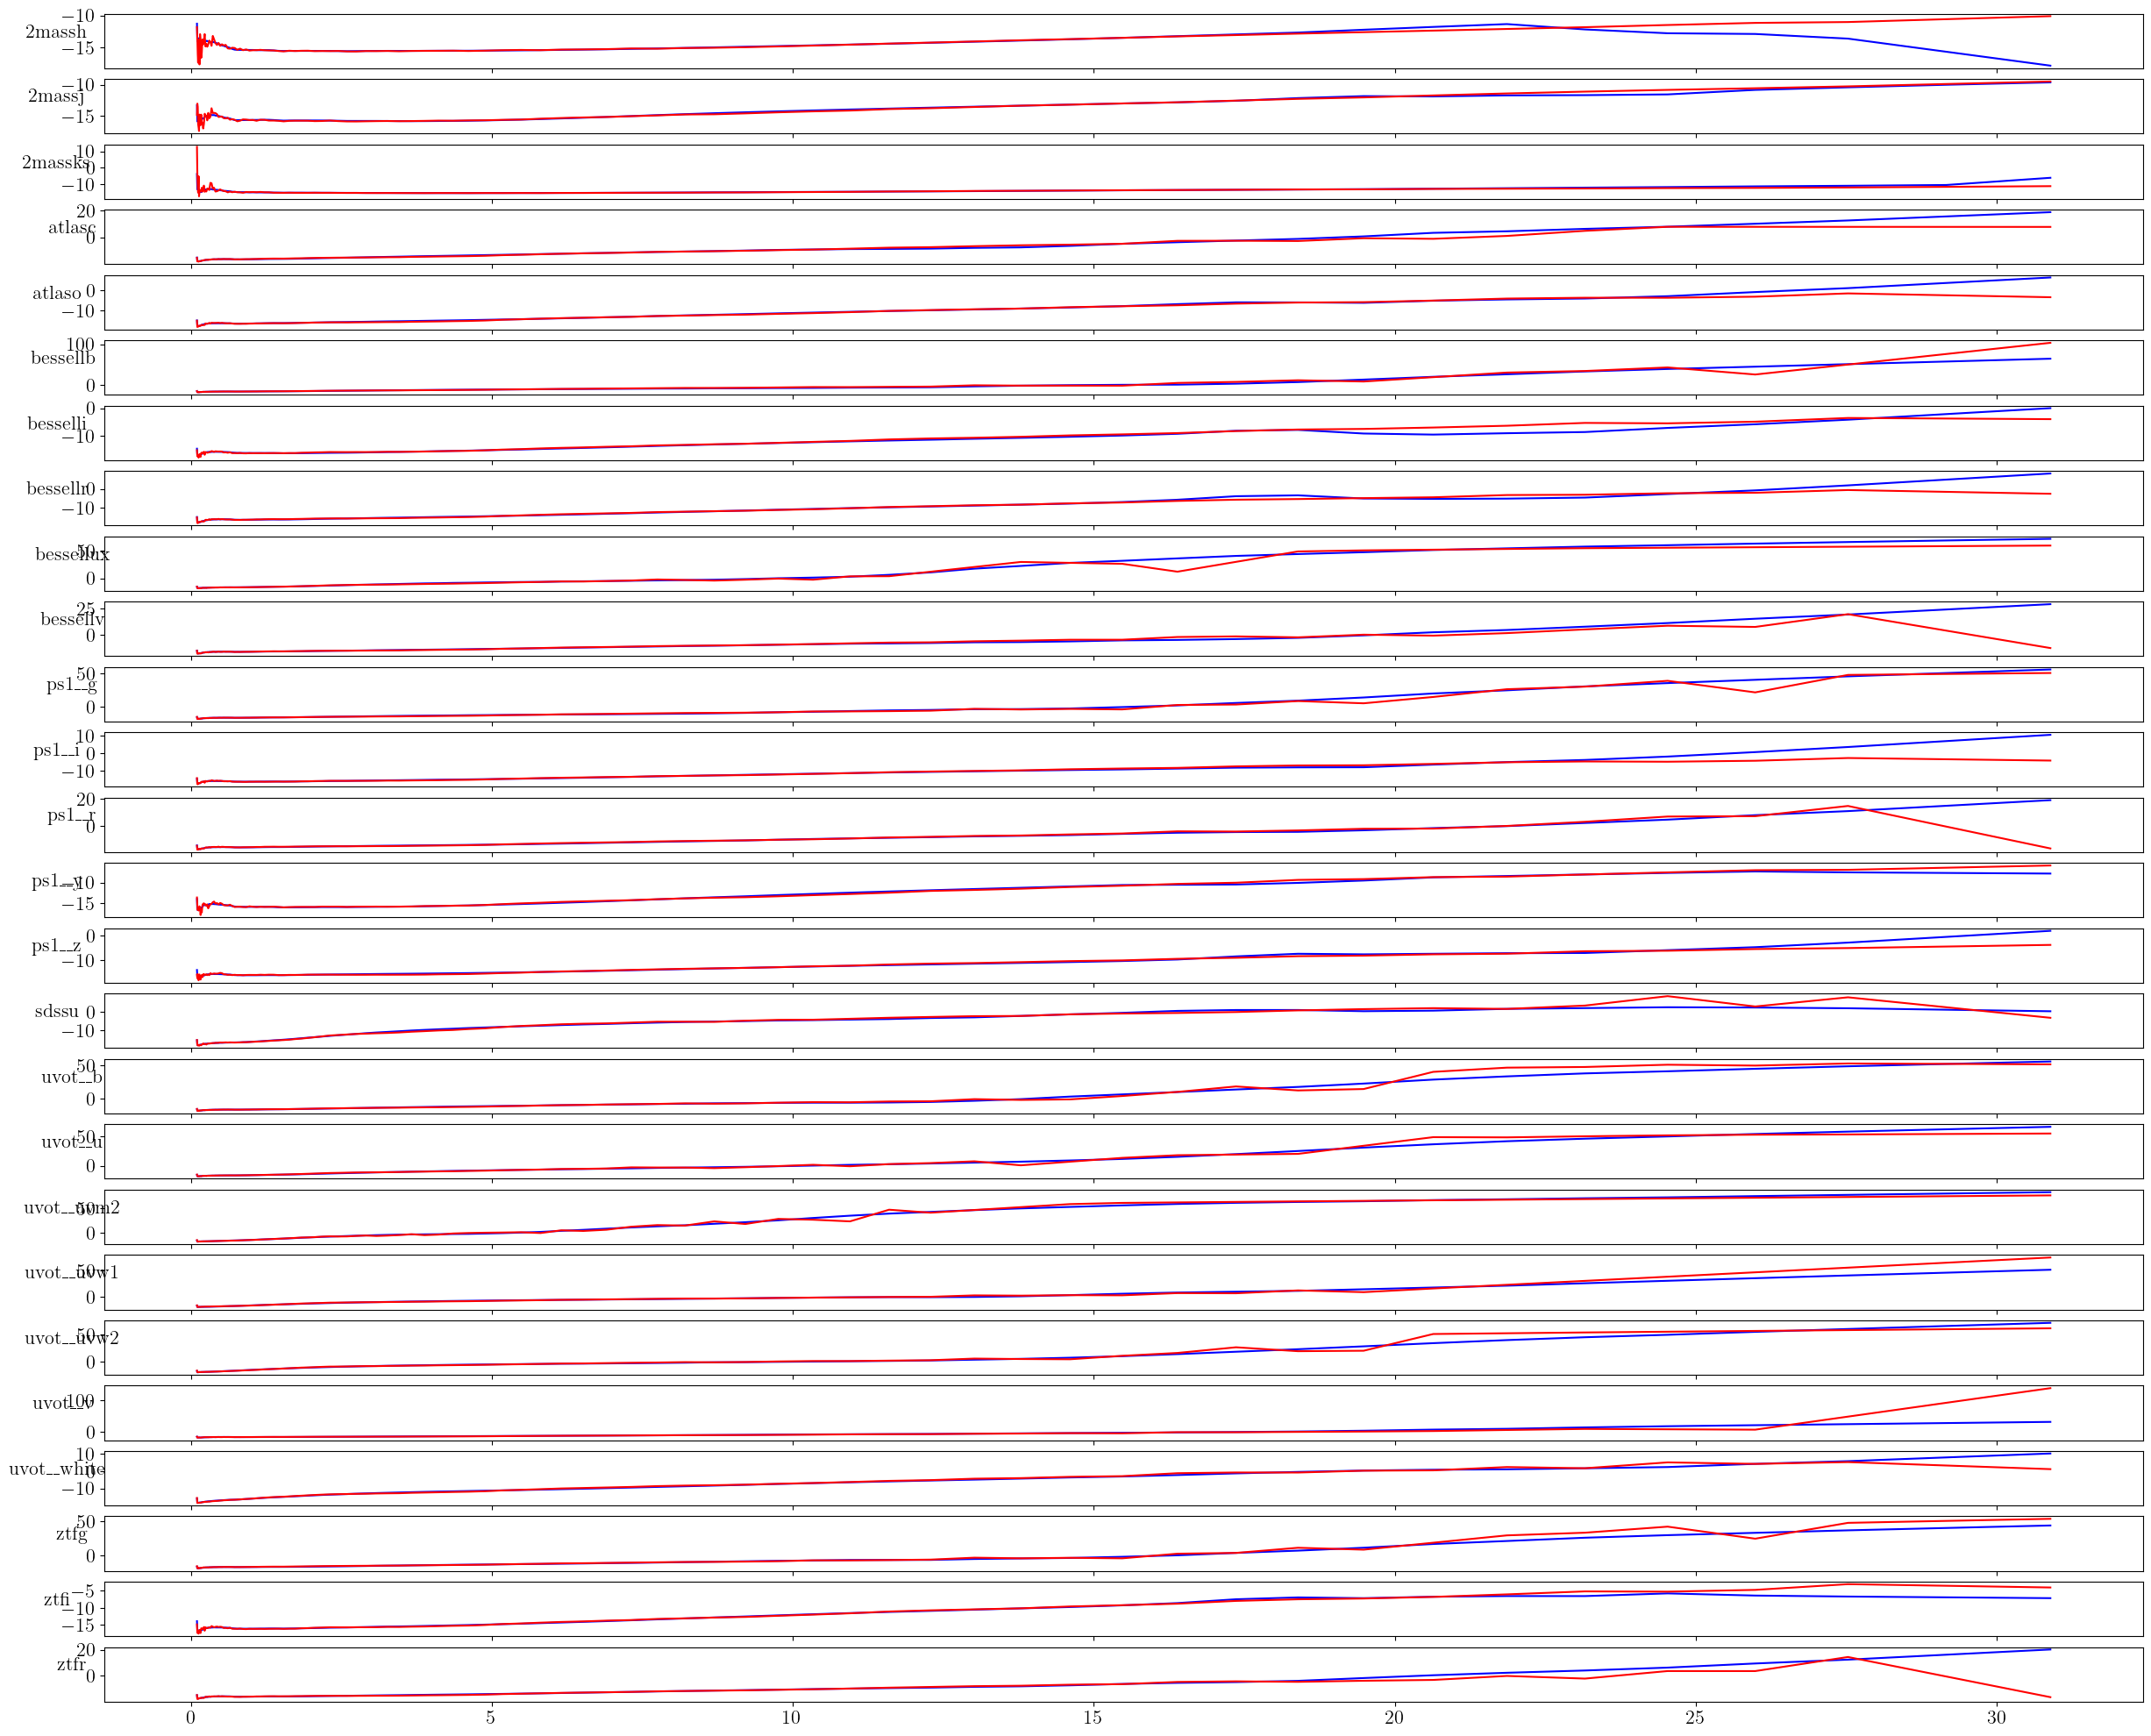

In [88]:
nrow = len(filts)
plt.subplots(nrow, 1, figsize=(30, 25), sharex = True)

for i, filt in enumerate(mAB):
    plt.subplot(nrow, 1, i+1)
    # Plot the surrogate output
    plt.plot(tt, mAB[filt], color="blue")
    # Also plot the raw data (also processed, interpolated etc)
    processed_data = training_model.svd_model[filt]["data_postprocess"][0] # TODO first entry is OK for comparison?
    mins = training_model.svd_model[filt]["mins"]
    maxs = training_model.svd_model[filt]["maxs"]
    raw_data = mins + (maxs - mins) * processed_data
    plt.plot(t, raw_data, color = "red")
    plt.ylabel(filt, rotation=0)
    plt.grid()
plt.show()

## Benchmarking surrogate model

We will benchmark the model by checking the MSE on the lightcurves, but up to a specific time of observation (since late times are unreliable anyway).

In [89]:
def mse(x: np.array, y: np.array):
    diff = x - y
    sq = jnp.dot(diff, diff)
    mean = jnp.mean(sq)
    return mean 

**TODO** Isn't this type of data already saved somewhere?

In [90]:
original_lcs = dict()

# Initialize this dict for every filter

for f in filts:
    original_lcs[f] = np.zeros((n_samples, 100))

In [91]:
for i, name in enumerate(filenames):
    # Get the original lc of this file
    lc = training_data[name[:-4]]["data"]
    # Save separate to every filter
    for j, f in enumerate(filts):
        original_lcs[f][i, :] = lc[:, j]

In [92]:
original_lcs[filts[0]].shape

(7700, 100)

Compute the surrogate lightcurves. Since this is quite computationally intensive, we use jit and vmap.

In [93]:
# X is same for every filter, doesnt matter which filter we pick
X = training_model.svd_model[filts[0]]['param_array_postprocess']
X = jnp.array(X) # turn to jax array

In [94]:
# Create lambda function for it with input params as batch
my_calc_lc = lambda x: nmma.em.utils.calc_lc_flax(t, x, svd_mag_model=training_model.svd_model)

# Jit the utils function
my_calc_lc_jit = my_calc_lc

# print(jax.make_jaxpr(my_calc_lc_jit)(X))

In [95]:
tt, lbol, surrogate_lcs = jax.vmap(my_calc_lc)(X)

In [96]:
mAB

{'2massh': DeviceArray([-11.309984 , -14.078512 , -13.529017 , -14.136217 ,
              -14.491911 , -14.294048 , -14.355591 , -14.395115 ,
              -14.556491 , -14.331825 , -14.105843 , -14.167561 ,
              -14.12019  , -14.132314 , -14.132927 , -14.128638 ,
              -14.011456 , -14.0341425, -14.098532 , -14.129352 ,
              -14.244413 , -14.208416 , -14.177692 , -14.236606 ,
              -14.305443 , -14.399684 , -14.527536 , -14.602187 ,
              -14.734288 , -14.801403 , -14.911892 , -15.005023 ,
              -15.121148 , -15.290592 , -15.40059  , -15.44031  ,
              -15.441151 , -15.448463 , -15.4345   , -15.452415 ,
              -15.452345 , -15.476615 , -15.487455 , -15.475329 ,
              -15.4790125, -15.527024 , -15.587699 , -15.611897 ,
              -15.601868 , -15.598648 , -15.595432 , -15.596808 ,
              -15.596371 , -15.601698 , -15.606214 , -15.621723 ,
              -15.64169  , -15.6279   , -15.613397 , -15.603095 ,


In [97]:
surrogate_lcs[filts[0]].shape

(7700, 100)

Verify if correct

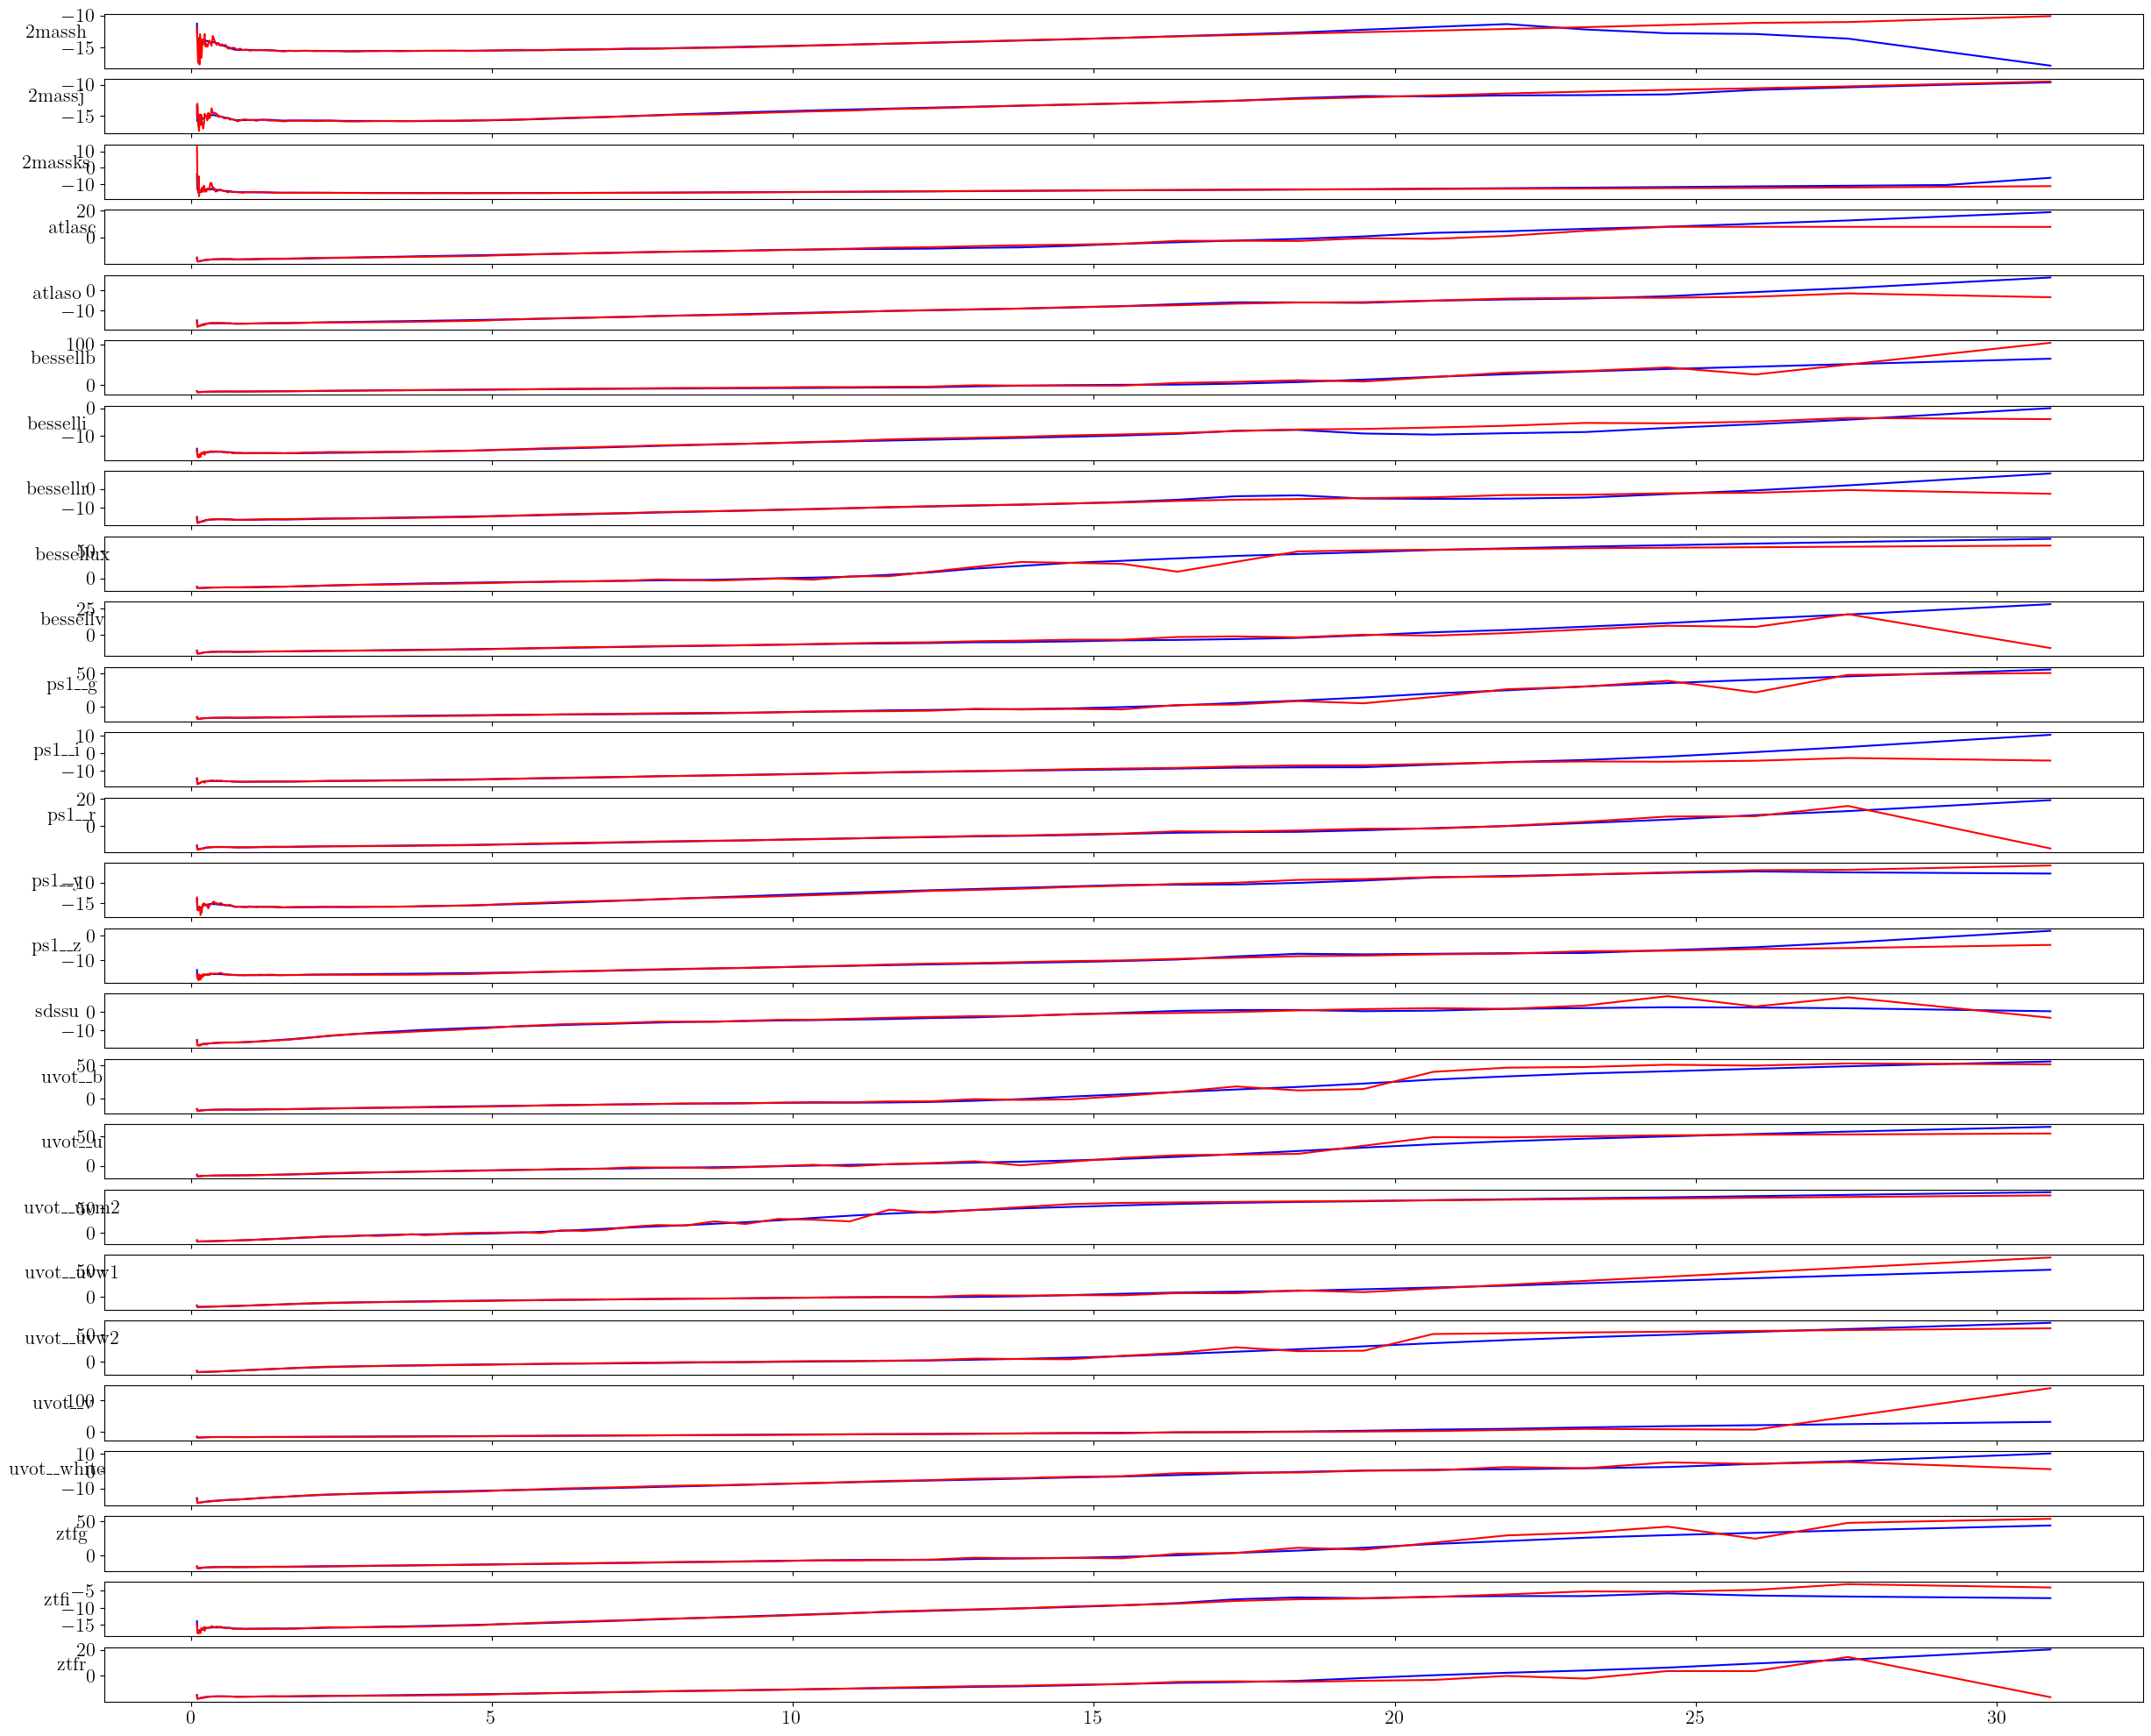

In [98]:
nrow = len(filts)
plt.subplots(nrow, 1, figsize=(30, 25), sharex = True)

for i, filt in enumerate(mAB):
    plt.subplot(nrow, 1, i+1)
    # Plot the surrogate output
    plt.plot(tt[0], surrogate_lcs[filt][0], color="blue")
    plt.plot(tt[0], original_lcs[filt][0], color="red")
    plt.ylabel(filt, rotation=0)
    plt.grid()
plt.show()

### Compute the MSE to compare the results

In [99]:
mse_dict = dict()

for f in filts:
    
    mse_values = jax.vmap(mse)(original_lcs[f].flatten(), surrogate_lcs[f].flatten())
    
    mse_dict[f] = mse_values

In [100]:
mse_dict[filts[0]].shape

(770000,)

In [101]:
## OLD (and slow) method:

# # Iterate over all the lightcurves
# for i, name in enumerate(filenames):
#     name = name[:-4]
#     print(name)
    
#     # Get the parameters
#     print(training_data[name])
#     params = np.zeros()
#     for p in parameters:
#         value = training_data[name][p]
#         params.append(value)
    
#     # Now get the surrogate model LC
#     tt, lbol, mAB = nmma.em.utils.calc_lc(t, params, svd_mag_model=training_model.svd_model, interpolation_type="flax") # , filters = filts, mag_ncoeff = svd_ncoeff

In [102]:
# mse_values = np.zeros(n_samples)


    
#     this_mse = 0
#     # Now compare on each filter and add MSE of each filter to mse of this LC
#     for f in filts:
#         # Get the original LC
#         processed_data = training_model.svd_model[f]["data_postprocess"][i]
#         mins = training_model.svd_model[f]["mins"]
#         maxs = training_model.svd_model[f]["maxs"]
#         raw_data = mins + (maxs - mins) * processed_data
#         # Get arrays for MSE
#         x = mAB[f]
#         y = raw_data
#         this_mse += mse(x, y)
    
#     # Save total MSE
#     mse_values[i] = this_mse
        

## Extra: Exploring the data as pictures

**Idea/question:** Instead of using the SVD, could we perhaps train directly on the lightcurve data, *and* at the same time learn all the filters, instead of a single neural network for every single filter independently? (The latter approach does not capture relations between the different filters.) The idea would be to train a CNN architecture that generates images such as the one below if given the merger parameters. 

(7700, 100)
(26, 100)


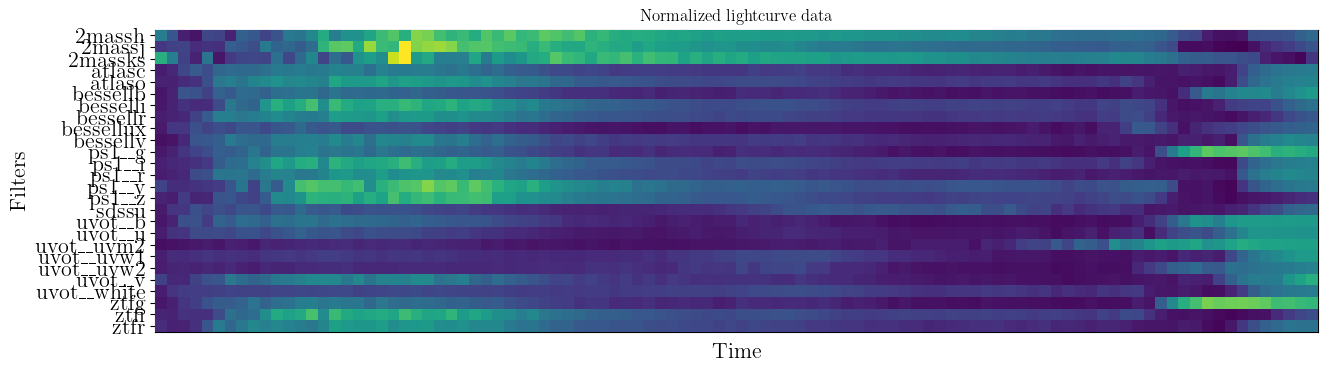

In [103]:
# Get the data
print(training_model.svd_model[filts[0]]['data_postprocess'].shape)
example_data = np.stack([training_model.svd_model[f]['data_postprocess'][0] for f in training_model.filters])
print(example_data.shape)

# Plot the data
no_ticks = False

plt.figure(figsize = (15, 12))
plt.imshow(example_data, zorder = 10)
# Labels
plt.xlabel("Time")
plt.ylabel("Filters")
# cbar = plt.colorbar()
# cbar.set_label("Normalized LC values")
plt.title("Normalized lightcurve data")
plt.xticks([])
plt.yticks([i for i in range(len(filts))], filts)
plt.show()

In [104]:
training_model.svd_model[filts[0]]['cAmat'].T[0]

array([-4.62778572, -0.36531729,  0.25260386, -0.06618868,  0.33647734,
        0.22141482,  0.00837703,  0.02129562,  0.01703494, -0.02540689])

Can also do the same idea with the SVD embedding. However, not sure how informative this is going to be...

In [105]:
# # Get the data
# example_data = np.stack([training_model.svd_model[f]['cAmat'].T[0] for f in training_model.filters])
# print(example_data.shape)

# # Plot the data
# no_ticks = False

# plt.figure(figsize = (15, 12))
# plt.imshow(example_data, zorder = 10)
# # Labels
# plt.xlabel("Time")
# plt.ylabel("Filters")
# # cbar = plt.colorbar()
# # cbar.set_label("Normalized LC values")
# plt.title("Embeddings")
# plt.xticks([])
# plt.yticks([i for i in range(len(filts))], filts)
# plt.show()

## Extra: Investigating PCA

**Idea/question:** The SVD uses 10 components by default. Is this good? Check the PCA as function of number of coefficients. *Edit:* Seems OK, not much to be improved here.

In [106]:
from sklearn.decomposition import PCA

In [107]:
training_model.svd_model['2massh']['data_postprocess'].shape

(7700, 100)

In [108]:
n_components = 0.95
pca = PCA(n_components = n_components)
pca.fit(training_model.svd_model['2massh']['data_postprocess'])
print(pca.n_components_)

14


In [109]:
pca.__dict__.keys()

dict_keys(['n_components', 'copy', 'whiten', 'svd_solver', 'tol', 'iterated_power', 'n_oversamples', 'power_iteration_normalizer', 'random_state', 'n_features_in_', '_fit_svd_solver', 'mean_', 'noise_variance_', 'n_samples_', 'n_features_', 'components_', 'n_components_', 'explained_variance_', 'explained_variance_ratio_', 'singular_values_'])

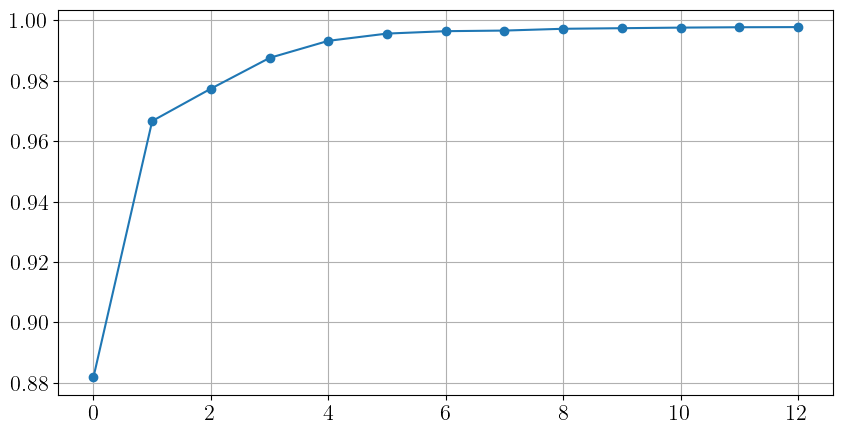

In [110]:
ratio = 1 - pca.explained_variance_ / np.cumsum(pca.explained_variance_)
ratio = 1 - pca.explained_variance_ratio_
plt.figure(figsize = (10, 5))
plt.plot(ratio[1:], '-o')
plt.show()